A* Fire Route Optimization

Overview
This Python script simulates a fire response system in a 10x10 city grid. Fire stations are positioned strategically, and emergency sites are predefined. The script dynamically calculates optimal routes for fire trucks using the A* pathfinding algorithm, considering blocked roads and traffic conditions. It also provides visualizations of the routes.

Key Components

City Grid Configuration:
• Grid Size: The city is represented as a 10x10 grid.
• Fire Stations: Fixed locations defined as coordinates. Each Fire Station has 2 Fire trucks.
• Emergency Sites: Predefined locations that require fire truck response.

Dynamic Traffic and Blockages
• Traffic Speeds: Default traffic speeds are initialized between neighboring nodes.
• Blocked Roads: A set of road segments where travel is not possible.

Visualization
• Utilizes matplotlib and networkx for plotting the city grid and fire truck routes.


Simulation

Road Blockages
Specific roads are blocked to simulate real-world conditions. 
• Example:
blocked_roads.add(((5, 5), (5, 6)))
blocked_roads.add(((10, 1), (10, 2)))

Emergency Dispatch
The script dispatches fire trucks at specific times based on predefined emergencies:
print("Time is 3:00")
dispatch_fire_trucks("3:00")


Visualization
The city grid and routes are visualized using NetworkX and Matplotlib. Key visual elements:

• Fire Stations: Red nodes.
• Emergency Sites: Green nodes.
• Blocked Roads: Dashed black lines.
• Fire Truck Routes: Colored paths.

Usage
Ensure all dependencies are installed:
• matplotlib
• networkx


Time is 3:00
Station (10, 10) responding to Site 7 at (9, 9)


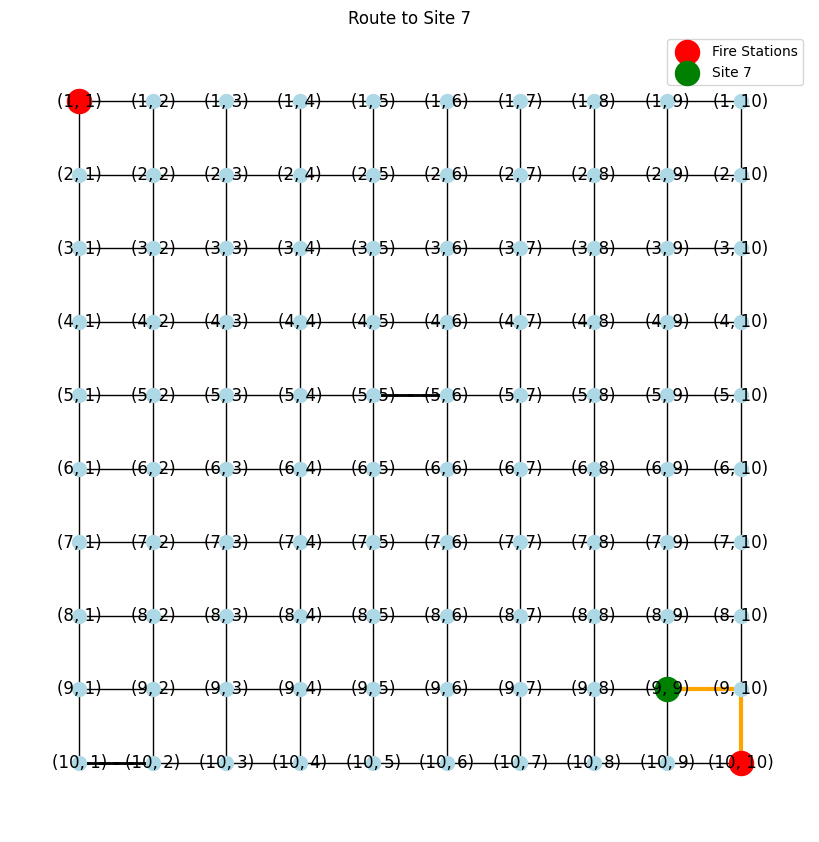

Station (1, 1) responding to Site 8 at (1, 8)


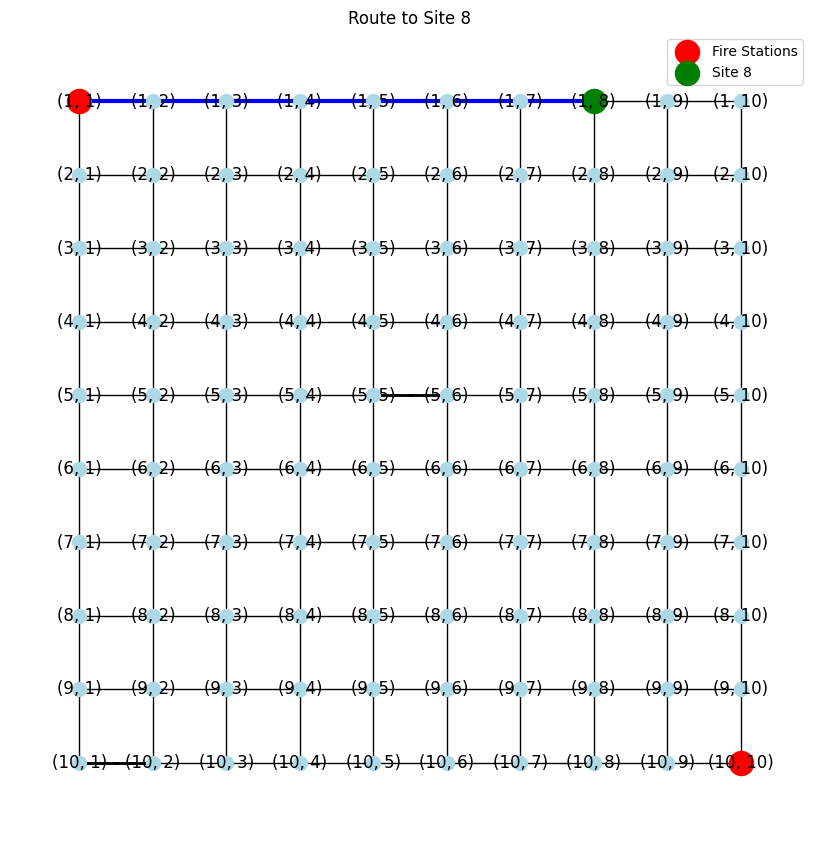

Station (10, 10) responding to Site 10 at (6, 7)


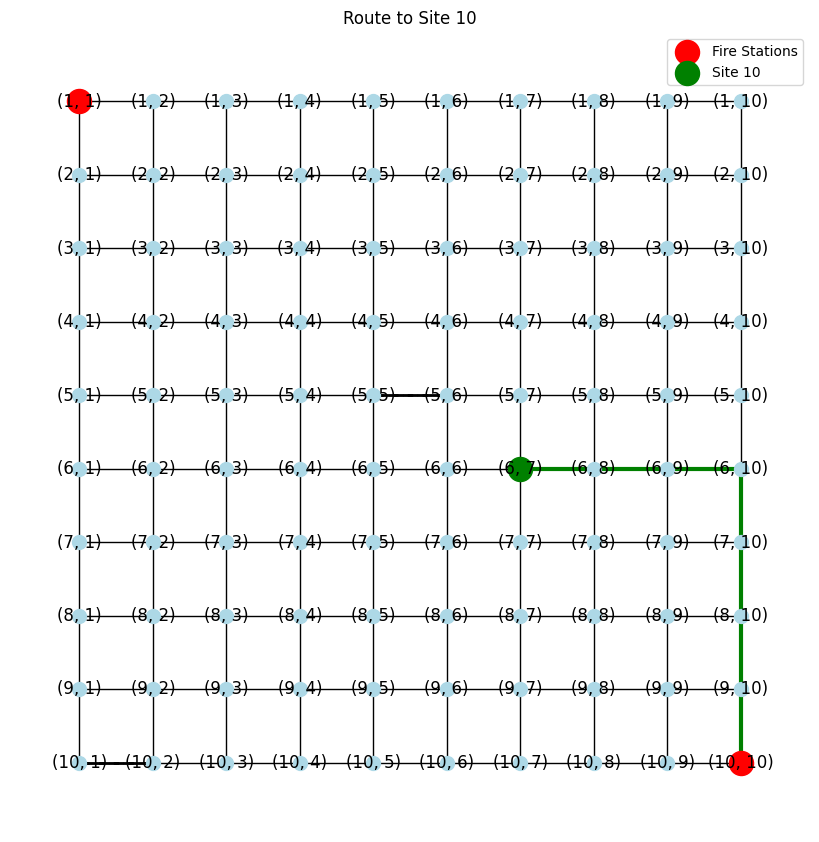

Time is 12:00
Station (1, 1) responding to Site 6 at (3, 6)


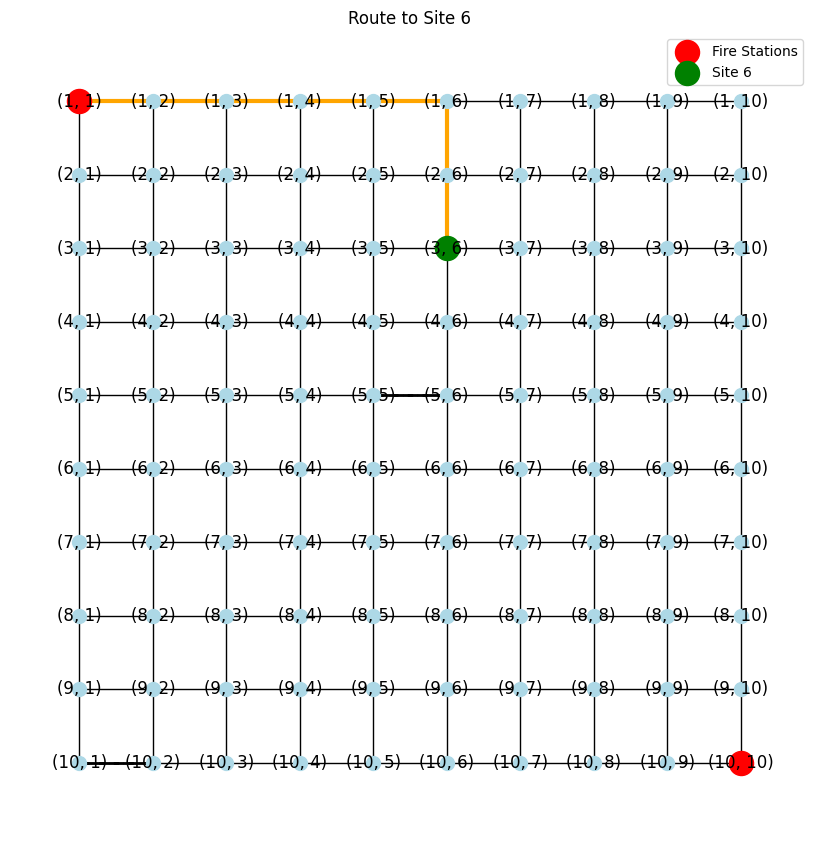

Station (1, 1) responding to Site 3 at (2, 9)


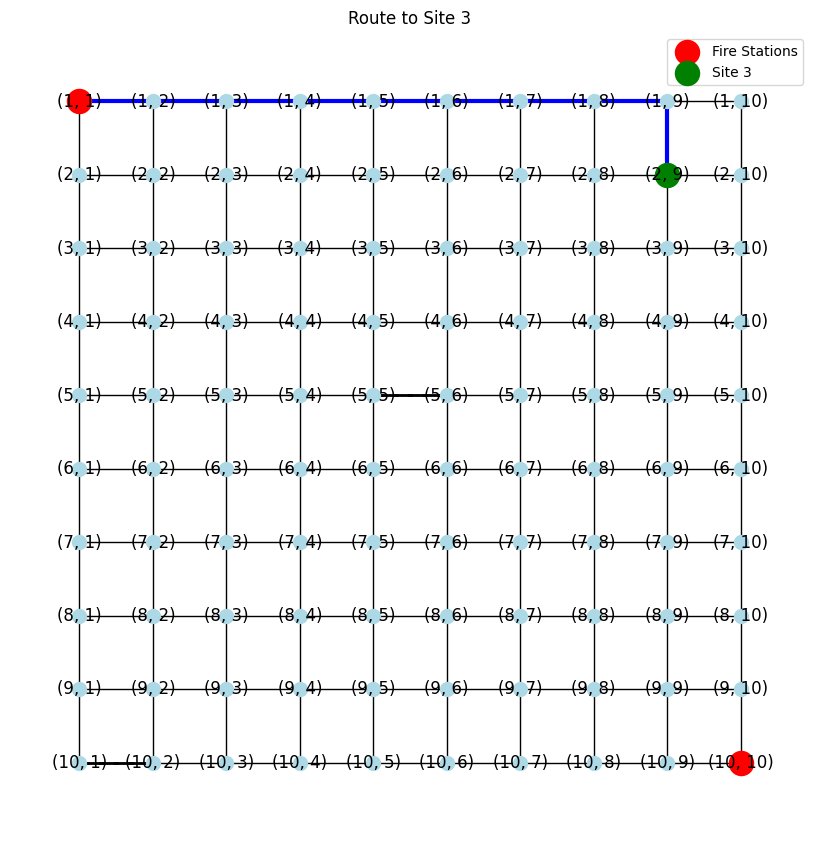

Time is 15:00
Station (1, 1) responding to Site 4 at (4, 4)


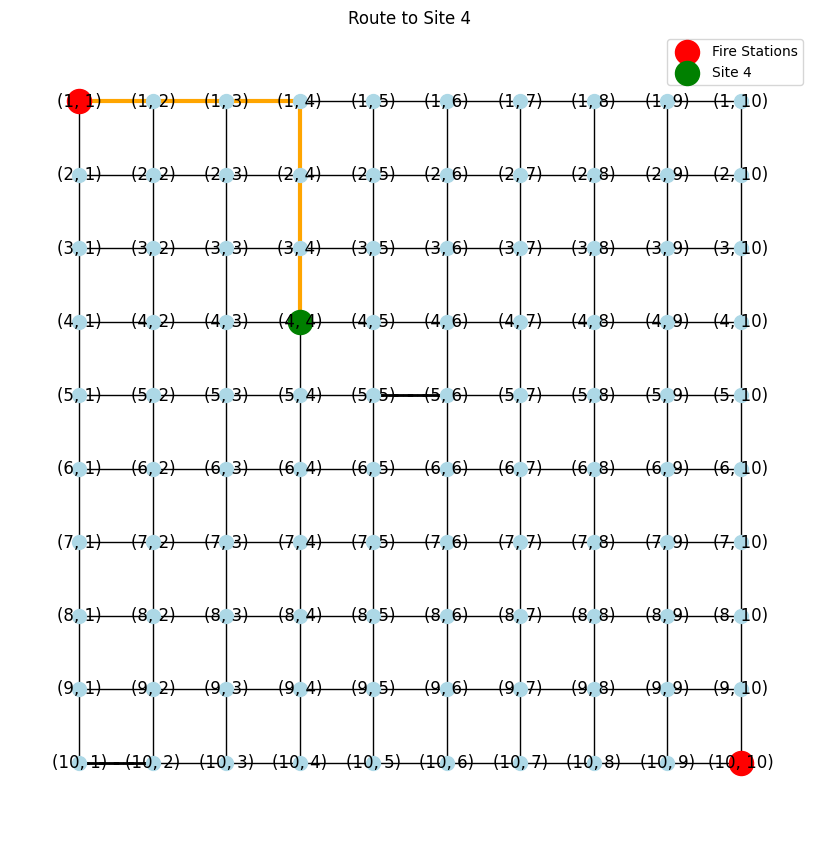

Station (1, 1) responding to Site 5 at (7, 2)


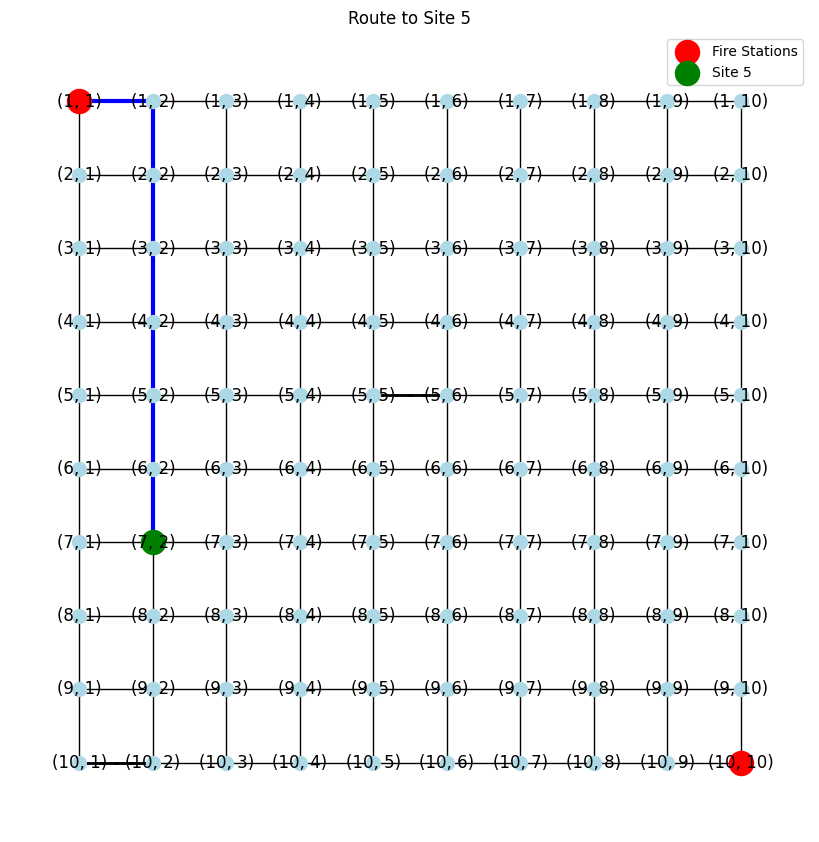

Station (10, 10) responding to Site 2 at (8, 3)


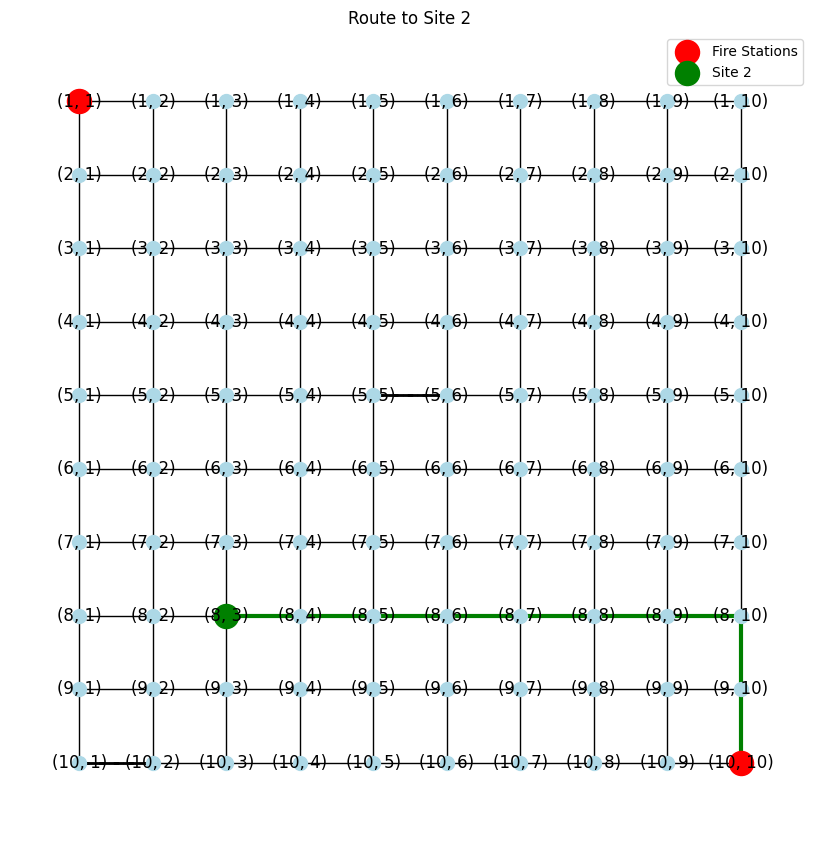

Station (10, 10) responding to Site 9 at (10, 1)


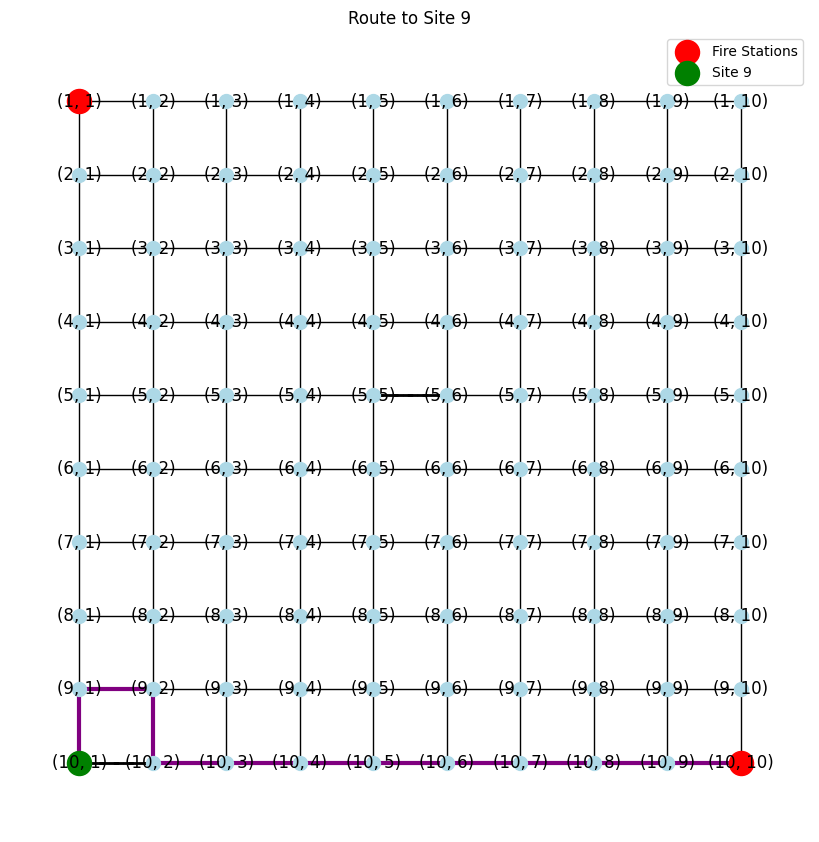

Time is 22:00
Station (1, 1) responding to Site 1 at (5, 5)


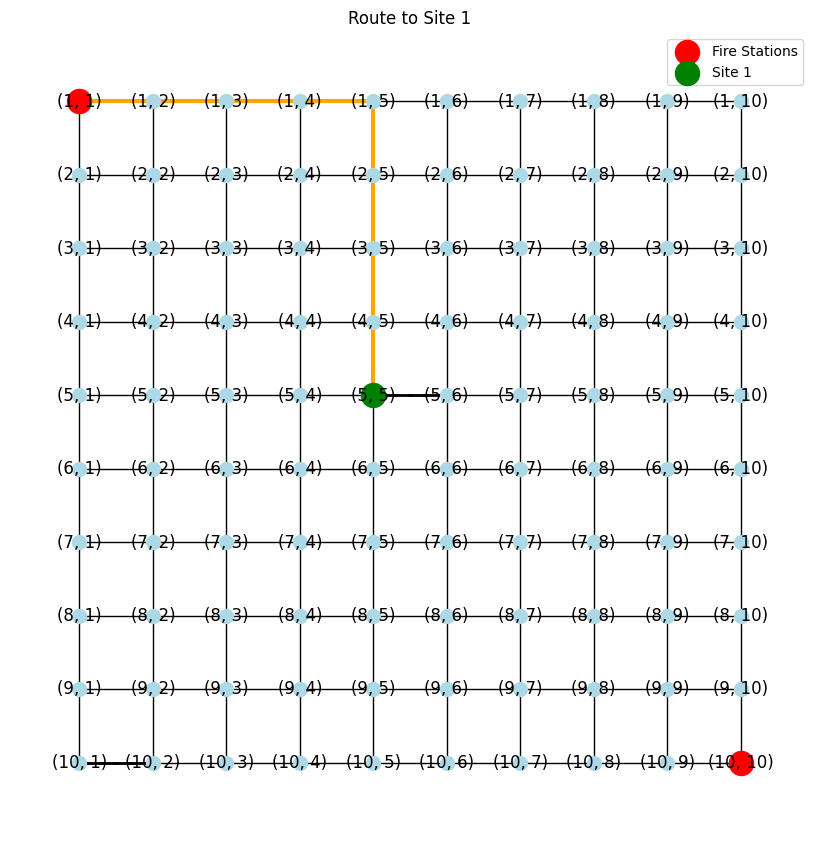

In [10]:
import heapq
import math
import matplotlib.pyplot as plt
import networkx as nx
import itertools

# City Grid Configuration
grid_size = 10  # 10x10 grid
fire_stations = [(1, 1), (10, 10)]  # Fire station coordinates mapped from 1-indexing
emergency_sites = {
    "Site 1": (5, 5),  # (x, y)
    "Site 2": (8, 3),
    "Site 3": (2, 9),
    "Site 4": (4, 4),
    "Site 5": (7, 2),
    "Site 6": (3, 6),
    "Site 7": (9, 9),
    "Site 8": (1, 8),
    "Site 9": (10, 1),
    "Site 10": (6, 7),
}

# Time-based simultaneous emergencies
time_based_emergencies = {
    "15:00": ["Site 2", "Site 4", "Site 5", "Site 9"],
    "12:00": ["Site 3", "Site 6"],
    "3:00": ["Site 7", "Site 8", "Site 10"],
    "22:00": ["Site 1"],
}

# Dynamic traffic data and road blockages
traffic_speeds = {}  # {(node1, node2): speed}
blocked_roads = set()  # Blocked roads: set of tuples {(node1, node2)}

# Visualization Graph
city_graph = nx.grid_2d_graph(grid_size, grid_size)
city_graph = nx.relabel_nodes(city_graph, lambda x: (x[0] + 1, x[1] + 1))

# Predefined colors for trucks
truck_colors = ["orange", "blue", "green", "purple", "brown", "cyan"]

def initialize_traffic():
    """Initialize default travel speeds between all neighboring nodes."""
    for x in range(1, grid_size + 1):
        for y in range(1, grid_size + 1):
            neighbors = get_neighbors((x, y))
            for n in neighbors:
                traffic_speeds[(x, y, n[0], n[1])] = 1  # Default speed 1 unit/sec

def get_neighbors(node):
    """Return valid neighboring nodes for a given node."""
    x, y = node
    neighbors = []
    if x > 1: neighbors.append((x - 1, y))
    if x < grid_size: neighbors.append((x + 1, y))
    if y > 1: neighbors.append((x, y - 1))
    if y < grid_size: neighbors.append((x, y + 1))
    return neighbors

def travel_time(node1, node2):
    """Calculate travel time between two nodes based on traffic speed."""
    if (node1, node2) in blocked_roads or (node2, node1) in blocked_roads:
        return math.inf  # Blocked road
    speed = traffic_speeds.get((node1[0], node1[1], node2[0], node2[1]), 1)
    return 1 / speed  # Time = distance (1 unit) / speed

def heuristic(node, goal):
    """Manhattan distance heuristic for A* algorithm."""
    return abs(node[0] - goal[0]) + abs(node[1] - goal[1])

def a_star(start, goal):
    """A* algorithm to find the shortest path from start to goal."""
    open_list = []
    heapq.heappush(open_list, (0, start))  # (priority, node)
    came_from = {}  # To reconstruct the path
    g_score = {start: 0}  # Cost from start to a node
    f_score = {start: heuristic(start, goal)}

    while open_list:
        _, current = heapq.heappop(open_list)
        if current == goal:
            return reconstruct_path(came_from, current)
        for neighbor in get_neighbors(current):
            t_time = travel_time(current, neighbor)
            if t_time == math.inf:
                continue  # Skip blocked roads
            tentative_g_score = g_score[current] + t_time
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_list, (f_score[neighbor], neighbor))
    return None  # No path found

def reconstruct_path(came_from, current):
    """Reconstruct the path from start to goal."""
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

def dispatch_fire_trucks(time):
    """Dispatch fire trucks to emergency sites active at the same time."""
    active_sites = time_based_emergencies.get(time, [])
    truck_idx = 0  # Track color index

    # Track available trucks at each station
    available_trucks = {station: 2 for station in fire_stations}

    # Create a list of distances between all stations and active sites
    distances = []
    for site_name in active_sites:
        site_location = emergency_sites[site_name]
        for station, trucks in available_trucks.items():
            if trucks > 0:
                dist = heuristic(station, site_location)
                distances.append((dist, station, site_name, site_location))

    # Sort distances to prioritize closer stations
    distances.sort()

    # Assign fire trucks based on closest available station
    assigned = set()
    for dist, station, site_name, site_location in distances:
        if site_name not in assigned and available_trucks[station] > 0:
            available_trucks[station] -= 1
            assigned.add(site_name)
            print(f"Station {station} responding to {site_name} at {site_location}")
            path = a_star(station, site_location)
            if path:
                plot_route(path, site_name, truck_colors[truck_idx % len(truck_colors)])
                truck_idx += 1

def plot_route(path, site, color):
    """Visualize the route on a city grid."""
    plt.figure(figsize=(8, 8))
    pos = {(x, y): (y, -x) for x, y in city_graph.nodes()}  # Update for valid positions

    # Draw grid
    nx.draw(city_graph, pos, node_size=100, node_color="lightblue", with_labels=True)

    # Highlight fire stations and emergency site
    nx.draw_networkx_nodes(city_graph, pos, nodelist=fire_stations, node_color="red", label="Fire Stations")
    nx.draw_networkx_nodes(city_graph, pos, nodelist=[path[-1]], node_color="green", label=f"{site}")
    nx.draw_networkx_edges(city_graph, pos, edgelist=blocked_roads, edge_color="black", width=2, style="dashed")

    # Highlight path
    edges = [(path[i], path[i + 1]) for i in range(len(path) - 1)]
    nx.draw_networkx_edges(city_graph, pos, edgelist=edges, edge_color=color, width=3)

    plt.title(f"Route to {site}")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    initialize_traffic()


    #New road block add kr skty hain Sir Ap, new route ayega

    # Simulate road blockage
    blocked_roads.add(((5, 5), (5, 6)))
    blocked_roads.add(((5, 6), (5, 5)))
    blocked_roads.add(((10, 1), (10, 2)))
    blocked_roads.add(((10, 2), (10, 1)))

    # Dispatch fire trucks at a specific time
    print("Time is 3:00")
    dispatch_fire_trucks("3:00")
    print("Time is 12:00")
    dispatch_fire_trucks("12:00")
    print("Time is 15:00")
    dispatch_fire_trucks("15:00")
    print("Time is 22:00")
    dispatch_fire_trucks("22:00")
